# `CNRatioModel` Tutorial

Trey V. Wenger (c) March 2025

`CNRatioModel` models both ${\rm CN}$ and $^{13}{\rm CN}$ spectral simultaneously in order to constrain the isotopic ratio $^{12}{\rm C}/^{13}{\rm C}$.

The ratio parameter `12C_13C_ratio` is only equivalent to the "true" isotopic ratio under the assumption that both species have the same excitation conditions (i.e., the same population fraction in the $N=0$ and $N=1$ states). This parameter is equivalent to the total column density ratio of all $N=0$ and $N=1$ states, $N_{\rm tot, CN}/N_{{\rm tot}, ^{13}\rm CN}$ where $N_{\rm tot} = \sum N_{N=0} + N_{N=1}$.

In [1]:
# General imports    
import os
import pickle
import time

import matplotlib.pyplot as plt
import arviz as az
import pandas as pd
import numpy as np
import pymc as pm

print("arviz version:", az.__version__)

print("pymc version:", pm.__version__)

import bayes_spec
print("bayes_spec version:", bayes_spec.__version__)

import bayes_cn_hfs
print("bayes_cn_hfs version:", bayes_cn_hfs.__version__)

# Notebook configuration
pd.options.display.max_rows = None

arviz version: 0.22.0dev
pymc version: 5.21.1
bayes_spec version: 1.7.5
bayes_cn_hfs version: 1.1.1+7.gce2c1a5.dirty


## Simulate Data

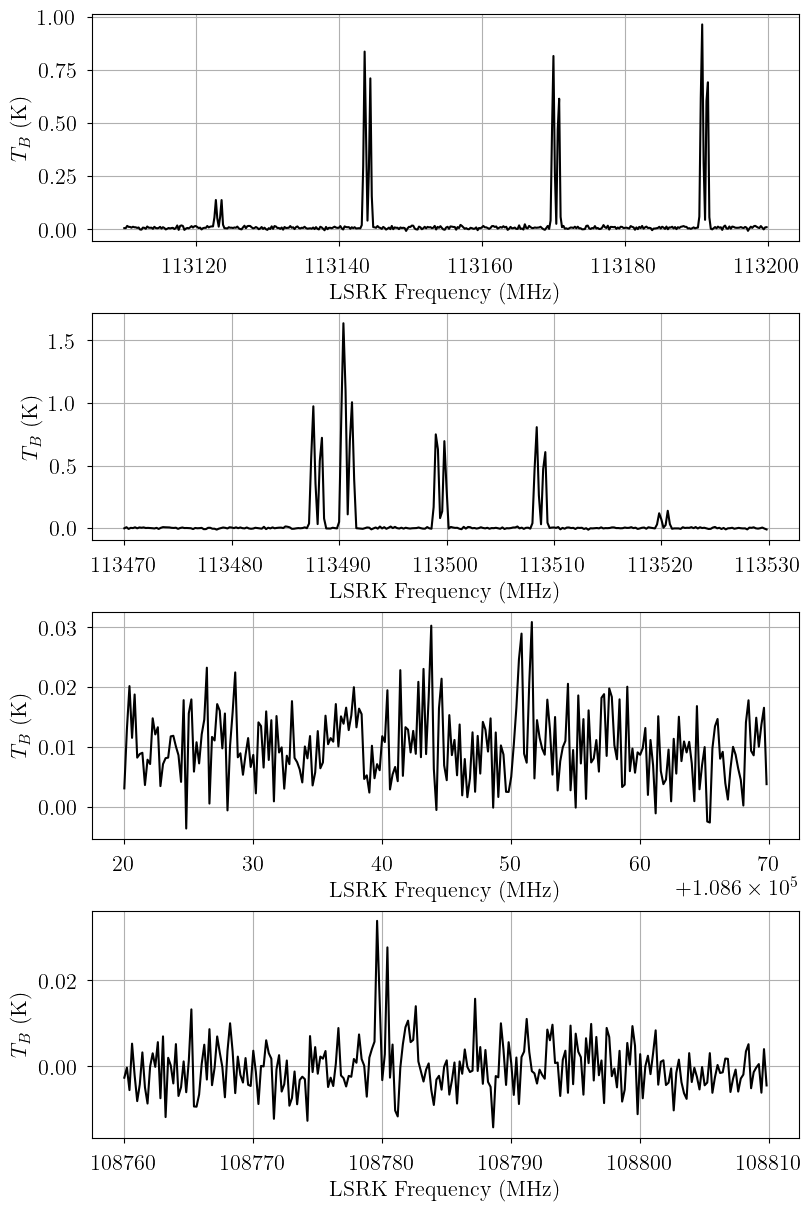

In [2]:
from bayes_spec import SpecData
from bayes_cn_hfs.cn_ratio_model import CNRatioModel

# spectral axis definition
freq_axis_12CN_1 = np.arange(113110.0, 113200.0, 0.2) # MHz
freq_axis_12CN_2 = np.arange(113470.0, 113530.0, 0.2) # MHz
freq_axis_13CN_1 = np.arange(108620.0, 108670.0, 0.2) # MHz
freq_axis_13CN_2 = np.arange(108760.0, 108810.0, 0.2) # MHz

# data noise can either be a scalar (assumed constant noise across the spectrum)
# or an array of the same length as the data
noise = 0.005 # K

# brightness data. In this case, we just throw in some random data for now
# since we are only doing this in order to simulate some actual data.
brightness_data_12CN_1 = noise * np.random.randn(len(freq_axis_12CN_1)) # K
brightness_data_12CN_2 = noise * np.random.randn(len(freq_axis_12CN_2)) # K
brightness_data_13CN_1 = noise * np.random.randn(len(freq_axis_13CN_1)) # K
brightness_data_13CN_2 = noise * np.random.randn(len(freq_axis_13CN_2)) # K

# CNRatioModel expects observation names to contain either "12CN" or "13CN"
observation_12CN_1 = SpecData(
    freq_axis_12CN_1,
    brightness_data_12CN_1,
    noise,
    xlabel=r"LSRK Frequency (MHz)",
    ylabel=r"CN $T_B$ (K)",
)
observation_12CN_2 = SpecData(
    freq_axis_12CN_2,
    brightness_data_12CN_2,
    noise,
    xlabel=r"LSRK Frequency (MHz)",
    ylabel=r"CN $T_B$ (K)",
)
observation_13CN_1 = SpecData(
    freq_axis_13CN_1,
    brightness_data_13CN_1,
    noise,
    xlabel=r"LSRK Frequency (MHz)",
    ylabel=r"$^{13}$CN $T_B$ (K)",
)
observation_13CN_2 = SpecData(
    freq_axis_13CN_2,
    brightness_data_13CN_2,
    noise,
    xlabel=r"LSRK Frequency (MHz)",
    ylabel=r"$^{13}$CN $T_B$ (K)",
)
dummy_data = {
    "12CN-1": observation_12CN_1,
    "12CN-2": observation_12CN_2,
    "13CN-1": observation_13CN_1,
    "13CN-2": observation_13CN_2,
}

# Initialize and define the model
n_clouds = 2 # number of cloud components
baseline_degree = 0 # polynomial baseline degree
model = CNRatioModel(
    dummy_data,
    bg_temp = 2.7, # assumed background temperature (K)
    Beff = 1.0, # beam efficiency
    Feff = 1.0, # forward efficiency
    n_clouds=n_clouds,
    baseline_degree=baseline_degree,
    seed=1234,
    verbose=True
)
model.add_priors(
    prior_log10_N_12CN = [13.5, 1.0], # mean and width of log10 12CN total column density prior (cm-2)
    prior_ratio_12C_13C = [75.0, 25.0], # mean and width of 12C/13C ratio prior
    prior_log10_Tkin = [1.0, 0.5], # mean and width of log10 kinetic temperature prior (K)
    prior_velocity = [0.0, 3.0], # mean and width of velocity prior (km/s)
    prior_fwhm_nonthermal = 1.0, # width of non-thermal broadening prior (km/s)
    prior_fwhm_L = None, # assume Gaussian line profile
    prior_rms = None, # do not infer spectral rms
    prior_baseline_coeffs = None, # use default baseline priors
    assume_LTE = True, # assume LTE
    prior_log10_Tex = None, # ignored for this LTE model
    assume_CTEX_12CN = True, # implied for this LTE model
    prior_LTE_precision = 100.0, # ignored for this LTE model
    assume_CTEX_13CN = True, # implied for this LTE model
    fix_log10_Tkin = None, # do not fix the kinetic temperature
    ordered = False, # do not assume optically-thin
)
model.add_likelihood()

sim_params = {
    "log10_N_12CN": [13.9, 13.8],
    "ratio_12C_13C": [65.0, 55.0],
    "log10_Tkin": [0.6, 0.7],
    "velocity": [-0.5, 1.5],
    "fwhm_nonthermal": [0.5, 0.75],
    "fwhm_L": 0.0,
    "baseline_12CN_norm": [0.0],
    "baseline_13CN_norm": [0.0],
}

# add derived quantities to sim_params
for key in model.cloud_deterministics:
    if key not in sim_params.keys():
        sim_params[key] = model.model[key].eval(sim_params, on_unused_input="ignore")

# Evaluate and save simulated observations
sim_12CN_1 = model.model["12CN-1"].eval(sim_params, on_unused_input="ignore")
sim_12CN_2 = model.model["12CN-2"].eval(sim_params, on_unused_input="ignore")
sim_13CN_1 = model.model["13CN-1"].eval(sim_params, on_unused_input="ignore")
sim_13CN_2 = model.model["13CN-2"].eval(sim_params, on_unused_input="ignore")

# pack simulated data
observation_12CN_1 = SpecData(
    freq_axis_12CN_1,
    sim_12CN_1,
    noise,
    xlabel=r"LSRK Frequency (MHz)",
    ylabel=r"$T_B$ (K)",
)
observation_12CN_2 = SpecData(
    freq_axis_12CN_2,
    sim_12CN_2,
    noise,
    xlabel=r"LSRK Frequency (MHz)",
    ylabel=r"$T_B$ (K)",
)
observation_13CN_1 = SpecData(
    freq_axis_13CN_1,
    sim_13CN_1,
    noise,
    xlabel=r"LSRK Frequency (MHz)",
    ylabel=r"$T_B$ (K)",
)
observation_13CN_2 = SpecData(
    freq_axis_13CN_2,
    sim_13CN_2,
    noise,
    xlabel=r"LSRK Frequency (MHz)",
    ylabel=r"$T_B$ (K)",
)
data = {
    "12CN-1": observation_12CN_1,
    "12CN-2": observation_12CN_2,
    "13CN-1": observation_13CN_1,
    "13CN-2": observation_13CN_2,
}

# Plot the simulated data
fig, axes = plt.subplots(4, layout="constrained", figsize=(8, 12))
for i, dataset in enumerate(data.values()):
    axes[i].plot(dataset.spectral, dataset.brightness, 'k-')
    axes[i].set_ylabel(dataset.ylabel)
    _ = axes[i].set_xlabel(dataset.xlabel)

In [3]:
sim_params

{'log10_N_12CN': [13.9, 13.8],
 'ratio_12C_13C': [65.0, 55.0],
 'log10_Tkin': [0.6, 0.7],
 'velocity': [-0.5, 1.5],
 'fwhm_nonthermal': [0.5, 0.75],
 'fwhm_L': 0.0,
 'baseline_12CN_norm': [0.0],
 'baseline_13CN_norm': [0.0],
 'fwhm_thermal_12CN': array([0.08371703, 0.09393205]),
 'fwhm_thermal_13CN': array([0.08215209, 0.09217616]),
 'fwhm_12CN': array([0.5069601 , 0.75585927]),
 'fwhm_13CN': array([0.50670402, 0.75564307]),
 'N_13CN': array([1.22204344e+12, 1.14719517e+12]),
 'log10_Tex_ul': array([0.6, 0.7]),
 'Tex_12CN': array([[3.98107171, 5.01187234],
        [3.98107171, 5.01187234],
        [3.98107171, 5.01187234],
        [3.98107171, 5.01187234],
        [3.98107171, 5.01187234],
        [3.98107171, 5.01187234],
        [3.98107171, 5.01187234],
        [3.98107171, 5.01187234],
        [3.98107171, 5.01187234]]),
 'tau_12CN': array([[0.03961643, 0.02451991],
        [0.32429648, 0.20071051],
        [0.31672379, 0.19603779],
        [0.41128963, 0.25456059],
        [0.4128

## Model Definition

In [4]:
# Initialize and define the model
model = CNRatioModel(
    data,
    bg_temp = 2.7, # assumed background temperature (K)
    Beff = 1.0, # beam efficiency
    Feff = 1.0, # forward efficiency
    n_clouds=n_clouds,
    baseline_degree=baseline_degree,
    seed=1234,
    verbose=True
)
model.add_priors(
    prior_log10_N_12CN = [13.5, 1.0], # mean and width of log10 12CN total column density prior (cm-2)
    prior_ratio_12C_13C = [75.0, 25.0], # mean and width of 12C/13C ratio prior
    prior_log10_Tkin = [1.0, 0.5], # mean and width of log10 kinetic temperature prior (K)
    prior_velocity = [0.0, 3.0], # mean and width of velocity prior (km/s)
    prior_fwhm_nonthermal = 1.0, # width of non-thermal broadening prior (km/s)
    prior_fwhm_L = None, # assume Gaussian line profile
    prior_rms = None, # do not infer spectral rms
    prior_baseline_coeffs = None, # use default baseline priors
    assume_LTE = True, # assume LTE
    prior_log10_Tex = None, # ignored for this LTE model
    assume_CTEX_12CN = True, # implied for this LTE model
    prior_LTE_precision = 100.0, # ignored for this LTE model
    assume_CTEX_13CN = True, # implied for this LTE model
    fix_log10_Tkin = None, # do not fix the kinetic temperature
    ordered = False, # do not assume optically-thin
)
model.add_likelihood()

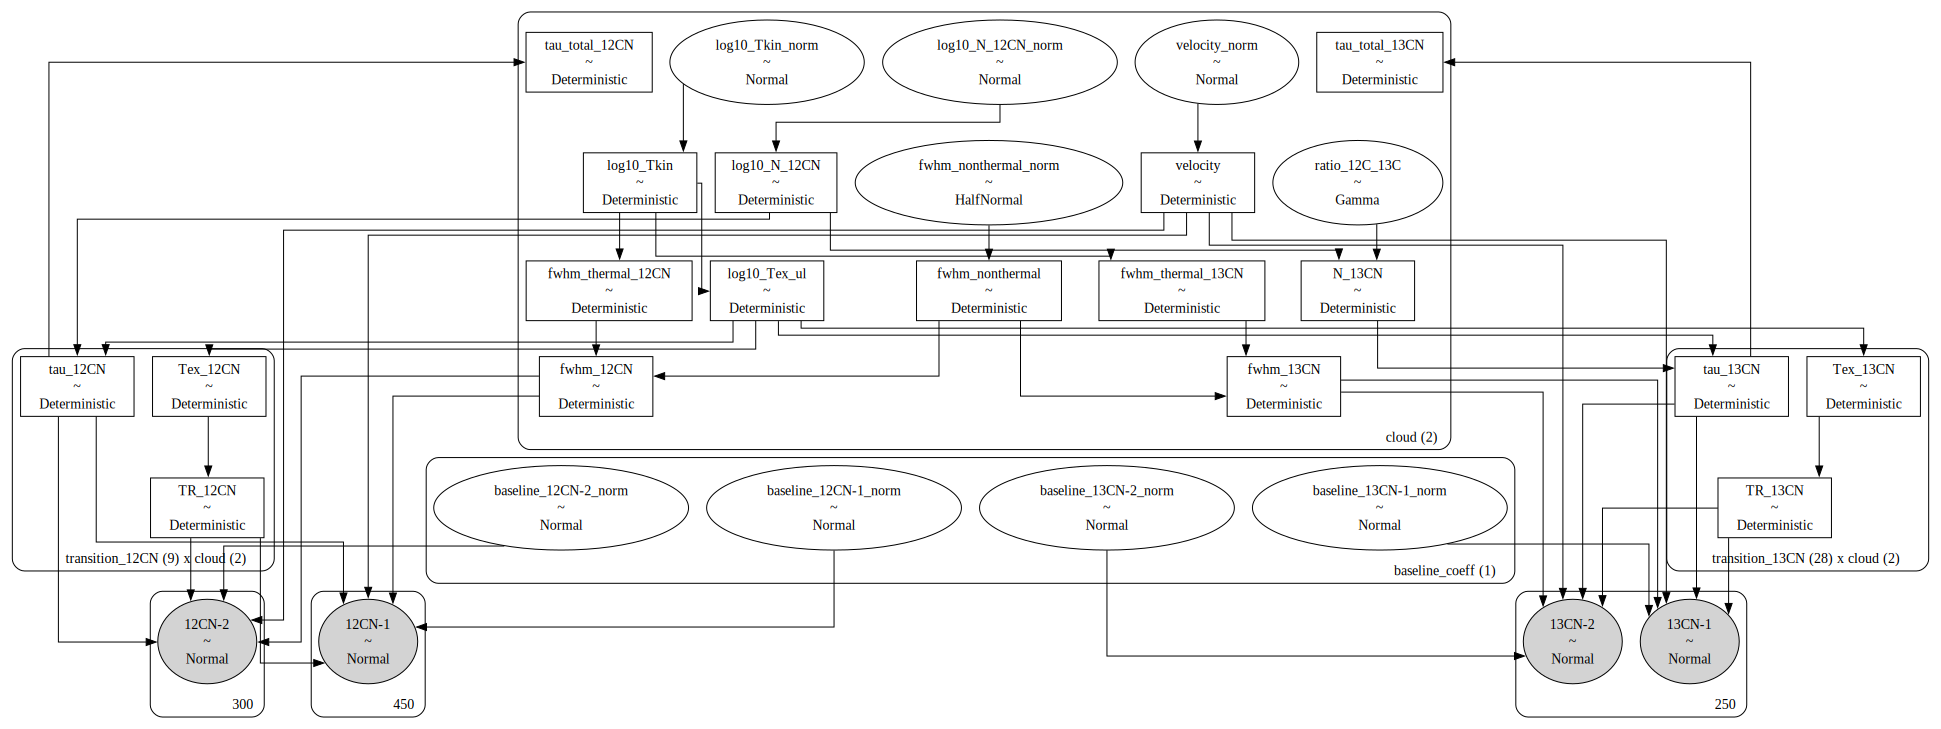

In [5]:
# Plot model graph
model.graph().render('cn_ratio_model', format='png')
model.graph()

In [6]:
# model string representation
print(model.model.str_repr())

baseline_12CN-1_norm ~ Normal(0, 1)
baseline_12CN-2_norm ~ Normal(0, 1)
baseline_13CN-1_norm ~ Normal(0, 1)
baseline_13CN-2_norm ~ Normal(0, 1)
       velocity_norm ~ Normal(0, 1)
     log10_Tkin_norm ~ Normal(0, 1)
fwhm_nonthermal_norm ~ HalfNormal(0, 1)
   log10_N_12CN_norm ~ Normal(0, 1)
       ratio_12C_13C ~ Gamma(9, f())
            velocity ~ Deterministic(f(velocity_norm))
          log10_Tkin ~ Deterministic(f(log10_Tkin_norm))
   fwhm_thermal_12CN ~ Deterministic(f(log10_Tkin_norm))
   fwhm_thermal_13CN ~ Deterministic(f(log10_Tkin_norm))
     fwhm_nonthermal ~ Deterministic(f(fwhm_nonthermal_norm))
           fwhm_12CN ~ Deterministic(f(fwhm_nonthermal_norm, log10_Tkin_norm))
           fwhm_13CN ~ Deterministic(f(fwhm_nonthermal_norm, log10_Tkin_norm))
        log10_N_12CN ~ Deterministic(f(log10_N_12CN_norm))
              N_13CN ~ Deterministic(f(ratio_12C_13C, log10_N_12CN_norm))
        log10_Tex_ul ~ Deterministic(f(log10_Tkin_norm))
            Tex_12CN ~ Deterministi

Sampling: [12CN-1, 12CN-2, 13CN-1, 13CN-2, baseline_12CN-1_norm, baseline_12CN-2_norm, baseline_13CN-1_norm, baseline_13CN-2_norm, fwhm_nonthermal_norm, log10_N_12CN_norm, log10_Tkin_norm, ratio_12C_13C, velocity_norm]


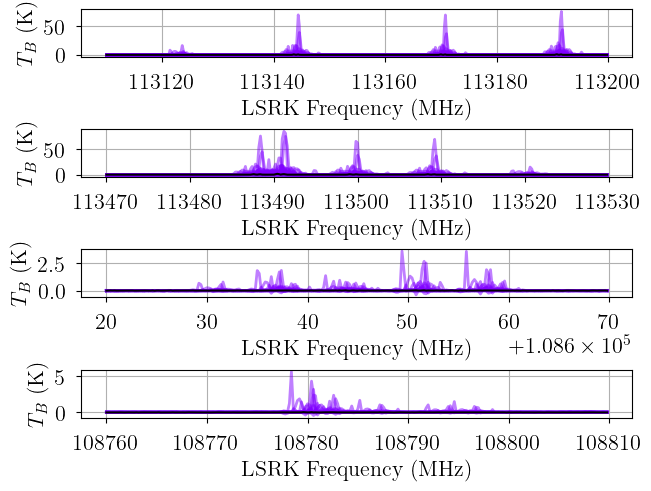

In [7]:
from bayes_spec.plots import plot_predictive

# prior predictive check
prior = model.sample_prior_predictive(
    samples=100,  # prior predictive samples
)
_ = plot_predictive(model.data, prior.prior_predictive)

baseline_freeRVs ['baseline_12CN-1_norm', 'baseline_12CN-2_norm', 'baseline_13CN-1_norm', 'baseline_13CN-2_norm']
baseline_deterministics []
cloud_freeRVs ['velocity_norm', 'log10_Tkin_norm', 'fwhm_nonthermal_norm', 'log10_N_12CN_norm', 'ratio_12C_13C']
cloud_deterministics ['velocity', 'log10_Tkin', 'fwhm_thermal_12CN', 'fwhm_thermal_13CN', 'fwhm_nonthermal', 'fwhm_12CN', 'fwhm_13CN', 'log10_N_12CN', 'N_13CN', 'log10_Tex_ul', 'Tex_12CN', 'tau_12CN', 'tau_total_12CN', 'TR_12CN', 'Tex_13CN', 'tau_13CN', 'tau_total_13CN', 'TR_13CN']
hyper_freeRVs []
hyper_deterministics []


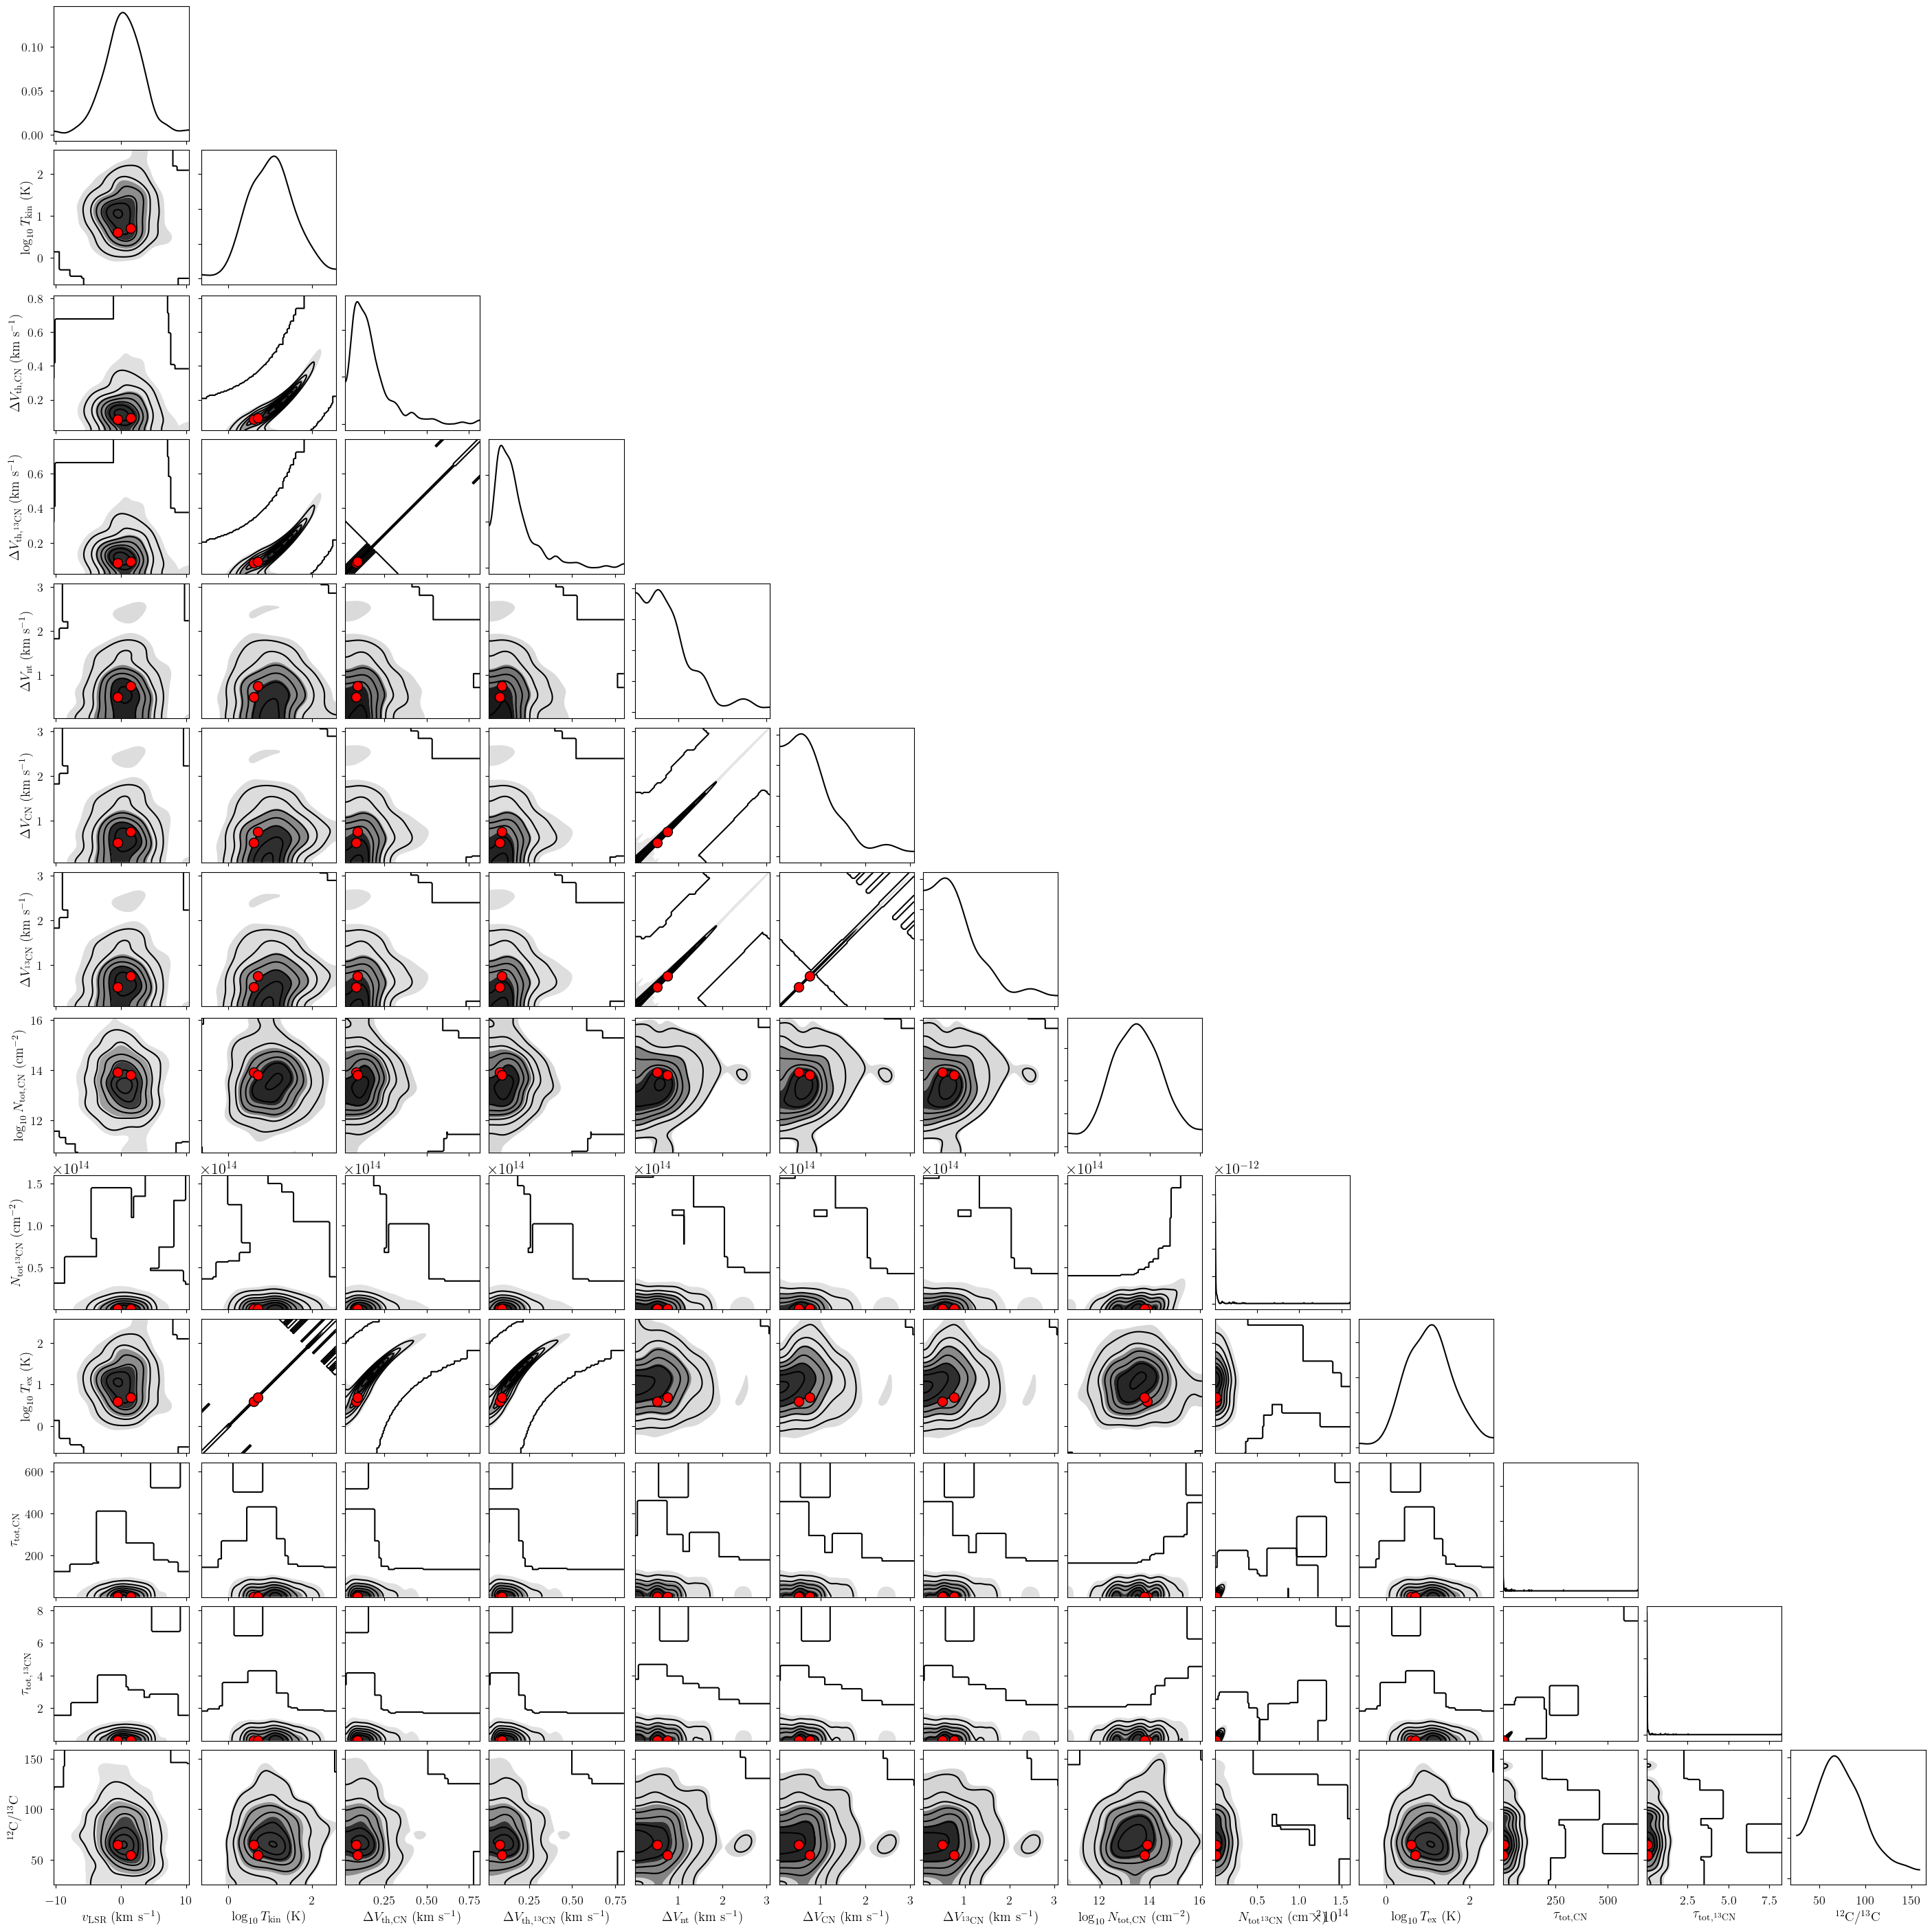

In [8]:
from bayes_spec.plots import plot_pair

# available parameter attributes:
print("baseline_freeRVs", model.baseline_freeRVs)
print("baseline_deterministics", model.baseline_deterministics)
print("cloud_freeRVs", model.cloud_freeRVs)
print("cloud_deterministics", model.cloud_deterministics)
print("hyper_freeRVs", model.hyper_freeRVs)
print("hyper_deterministics", model.hyper_deterministics)

# ignore transition and state dependent parameters
var_names = [
    param for param in model.cloud_deterministics
    if not set(model.model.named_vars_to_dims[param]).intersection(set(
        ["transition_12CN", "state_12CN", "transition_13CN", "state_13CN"]
    ))
]
_ = plot_pair(
    prior.prior, # samples
    var_names + ["ratio_12C_13C"], # var_names to plot
    labeller=model.labeller, # label manager
    kind="kde", # plot type
    reference_values=sim_params, # truths
)

## Variational Inference

In [9]:
start = time.time()
model.fit(
    n = 100_000, # maximum number of VI iterations
    draws = 1_000, # number of posterior samples
    rel_tolerance = 0.01, # VI relative convergence threshold
    abs_tolerance = 0.1, # VI absolute convergence threshold
    learning_rate = 0.01, # VI learning rate
)
end = time.time()
print(f"Runtime: {(end-start)/60.0:.2f} minutes")

Output()

Convergence achieved at 5100
Interrupted at 5,099 [5%]: Average Loss = 1.7692e+05


Output()

Runtime: 0.45 minutes


Sampling: [12CN-1, 12CN-2, 13CN-1, 13CN-2]


Output()

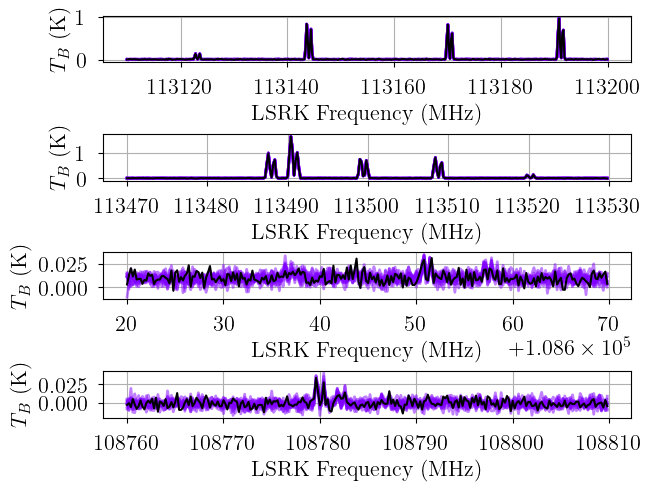

In [10]:
posterior = model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
_ = plot_predictive(model.data, posterior.posterior_predictive)

## Posterior Sampling: MCMC

In [11]:
start = time.time()
init_kwargs = {
    "rel_tolerance": 0.01,
    "abs_tolerance": 0.1,
    "learning_rate": 0.02,
}
model.sample(
    init = "advi+adapt_diag", # initialization strategy
    tune = 1000, # tuning samples
    draws = 1000, # posterior samples
    chains = 8, # number of independent chains
    cores = 8, # number of parallel chains
    init_kwargs = init_kwargs, # VI initialization arguments
    nuts_kwargs = {"target_accept": 0.8}, # NUTS arguments
)
end = time.time()
print(f"Runtime: {(end-start)/60.0:.2f} minutes")

Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 3600
Interrupted at 3,599 [3%]: Average Loss = 1.2102e+05
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [baseline_12CN-1_norm, baseline_12CN-2_norm, baseline_13CN-1_norm, baseline_13CN-2_norm, velocity_norm, log10_Tkin_norm, fwhm_nonthermal_norm, log10_N_12CN_norm, ratio_12C_13C]


Output()

Sampling 8 chains for 1_000 tune and 1_000 draw iterations (8_000 + 8_000 draws total) took 67 seconds.


Adding log-likelihood to trace


Output()

Runtime: 1.75 minutes


In [12]:
model.solve(kl_div_threshold=0.1)

GMM converged to unique solution


In [13]:
print("solutions:", model.solutions)

pm.summary(model.trace.solution_0)

solutions: [0]


mean            sd        hdi_3%  \
baseline_12CN-1_norm[0]  -3.400000e-02  4.800000e-02 -1.200000e-01   
baseline_12CN-2_norm[0]  -1.350000e-01  6.100000e-02 -2.410000e-01   
baseline_13CN-1_norm[0]  -5.100000e-02  6.600000e-02 -1.730000e-01   
baseline_13CN-2_norm[0]  -1.110000e-01  6.400000e-02 -2.260000e-01   
velocity_norm[0]          5.000000e-01  0.000000e+00  5.000000e-01   
velocity_norm[1]         -1.660000e-01  0.000000e+00 -1.670000e-01   
log10_Tkin_norm[0]       -6.020000e-01  2.000000e-03 -6.060000e-01   
log10_Tkin_norm[1]       -8.000000e-01  1.000000e-03 -8.020000e-01   
log10_N_12CN_norm[0]      3.020000e-01  3.000000e-03  2.980000e-01   
log10_N_12CN_norm[1]      3.990000e-01  4.000000e-03  3.920000e-01   
fwhm_nonthermal_norm[0]   7.480000e-01  2.000000e-03  7.440000e-01   
fwhm_nonthermal_norm[1]   4.960000e-01  3.000000e-03  4.900000e-01   
ratio_12C_13C[0]          6.488800e+01  6.297000e+00  5.344200e+01   
ratio_12C_13C[1]          7.461100e+01  7.997000e+00  6.059100e+01   
velocity[0]               1.500000e+00  1.000000e-03  1.499000e+00   
velocity[1]              -4.990000e-01  1.000000e-03 -5.010000e-01   
log10_Tkin[0]             6.990000e-01  1.000000e-03  6.970000e-01   
log10_Tkin[1]             6.000000e-01  1.000000e-03  5.990000e-01   
fwhm_thermal_12CN[0]      9.400000e-02  0.000000e+00  9.400000e-02   
fwhm_thermal_12CN[1]      8.400000e-02  0.000000e+00  8.400000e-02   
fwhm_thermal_13CN[0]      9.200000e-02  0.000000e+00  9.200000e-02   
fwhm_thermal_13CN[1]      8.200000e-02  0.000000e+00  8.200000e-02   
fwhm_nonthermal[0]        7.480000e-01  2.000000e-03  7.440000e-01   
fwhm_nonthermal[1]        4.960000e-01  3.000000e-03  4.900000e-01   
fwhm_12CN[0]              7.540000e-01  2.000000e-03  7.500000e-01   
fwhm_12CN[1]              5.030000e-01  3.000000e-03  4.970000e-01   
fwhm_13CN[0]              7.540000e-01  2.000000e-03  7.500000e-01   
fwhm_13CN[1]              5.030000e-01  3.000000e-03  4.970000e-01   
log10_N_12CN[0]           1.380200e+01  3.000000e-03  1.379800e+01   
log10_N_12CN[1]           1.389900e+01  4.000000e-03  1.389200e+01   
N_13CN[0]                 9.868061e+11  9.318424e+10  8.191535e+11   
N_13CN[1]                 1.074679e+12  1.113915e+11  8.645697e+11   
log10_Tex_ul[0]           6.990000e-01  1.000000e-03  6.970000e-01   
log10_Tex_ul[1]           6.000000e-01  1.000000e-03  5.990000e-01   
Tex_12CN[113123.3687, 0]  5.001000e+00  1.200000e-02  4.978000e+00   
Tex_12CN[113123.3687, 1]  3.983000e+00  7.000000e-03  3.970000e+00   
Tex_12CN[113144.19, 0]    5.001000e+00  1.200000e-02  4.978000e+00   
Tex_12CN[113144.19, 1]    3.983000e+00  7.000000e-03  3.970000e+00   
Tex_12CN[113170.535, 0]   5.001000e+00  1.200000e-02  4.978000e+00   
Tex_12CN[113170.535, 1]   3.983000e+00  7.000000e-03  3.970000e+00   
Tex_12CN[113191.325, 0]   5.001000e+00  1.200000e-02  4.978000e+00   
Tex_12CN[113191.325, 1]   3.983000e+00  7.000000e-03  3.970000e+00   
Tex_12CN[113488.142, 0]   5.001000e+00  1.200000e-02  4.978000e+00   
Tex_12CN[113488.142, 1]   3.983000e+00  7.000000e-03  3.970000e+00   
Tex_12CN[113490.985, 0]   5.001000e+00  1.200000e-02  4.978000e+00   
Tex_12CN[113490.985, 1]   3.983000e+00  7.000000e-03  3.970000e+00   
Tex_12CN[113499.643, 0]   5.001000e+00  1.200000e-02  4.978000e+00   
Tex_12CN[113499.643, 1]   3.983000e+00  7.000000e-03  3.970000e+00   
Tex_12CN[113508.934, 0]   5.001000e+00  1.200000e-02  4.978000e+00   
Tex_12CN[113508.934, 1]   3.983000e+00  7.000000e-03  3.970000e+00   
Tex_12CN[113520.4215, 0]  5.001000e+00  1.200000e-02  4.978000e+00   
Tex_12CN[113520.4215, 1]  3.983000e+00  7.000000e-03  3.970000e+00   
tau_12CN[113123.3687, 0]  2.500000e-02  0.000000e+00  2.400000e-02   
tau_12CN[113123.3687, 1]  4.000000e-02  0.000000e+00  3.900000e-02   
tau_12CN[113144.19, 0]    2.020000e-01  2.000000e-03  1.990000e-01   
tau_12CN[113144.19, 1]    3.240000e-01  3.000000e-03  3.180000e-01   
tau_12CN[113170.535, 0]   1.980000e-01  2.00

Sampling: [12CN-1, 12CN-2, 13CN-1, 13CN-2]


Output()

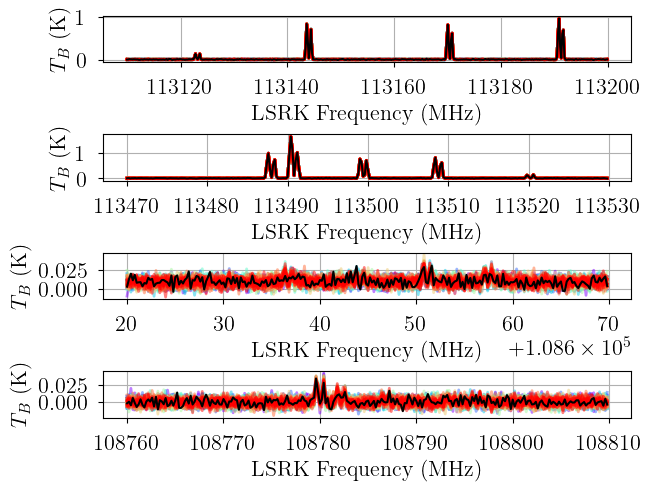

In [14]:
posterior = model.sample_posterior_predictive(
    thin=100, # keep one in {thin} posterior samples
)
_ = plot_predictive(model.data, posterior.posterior_predictive)

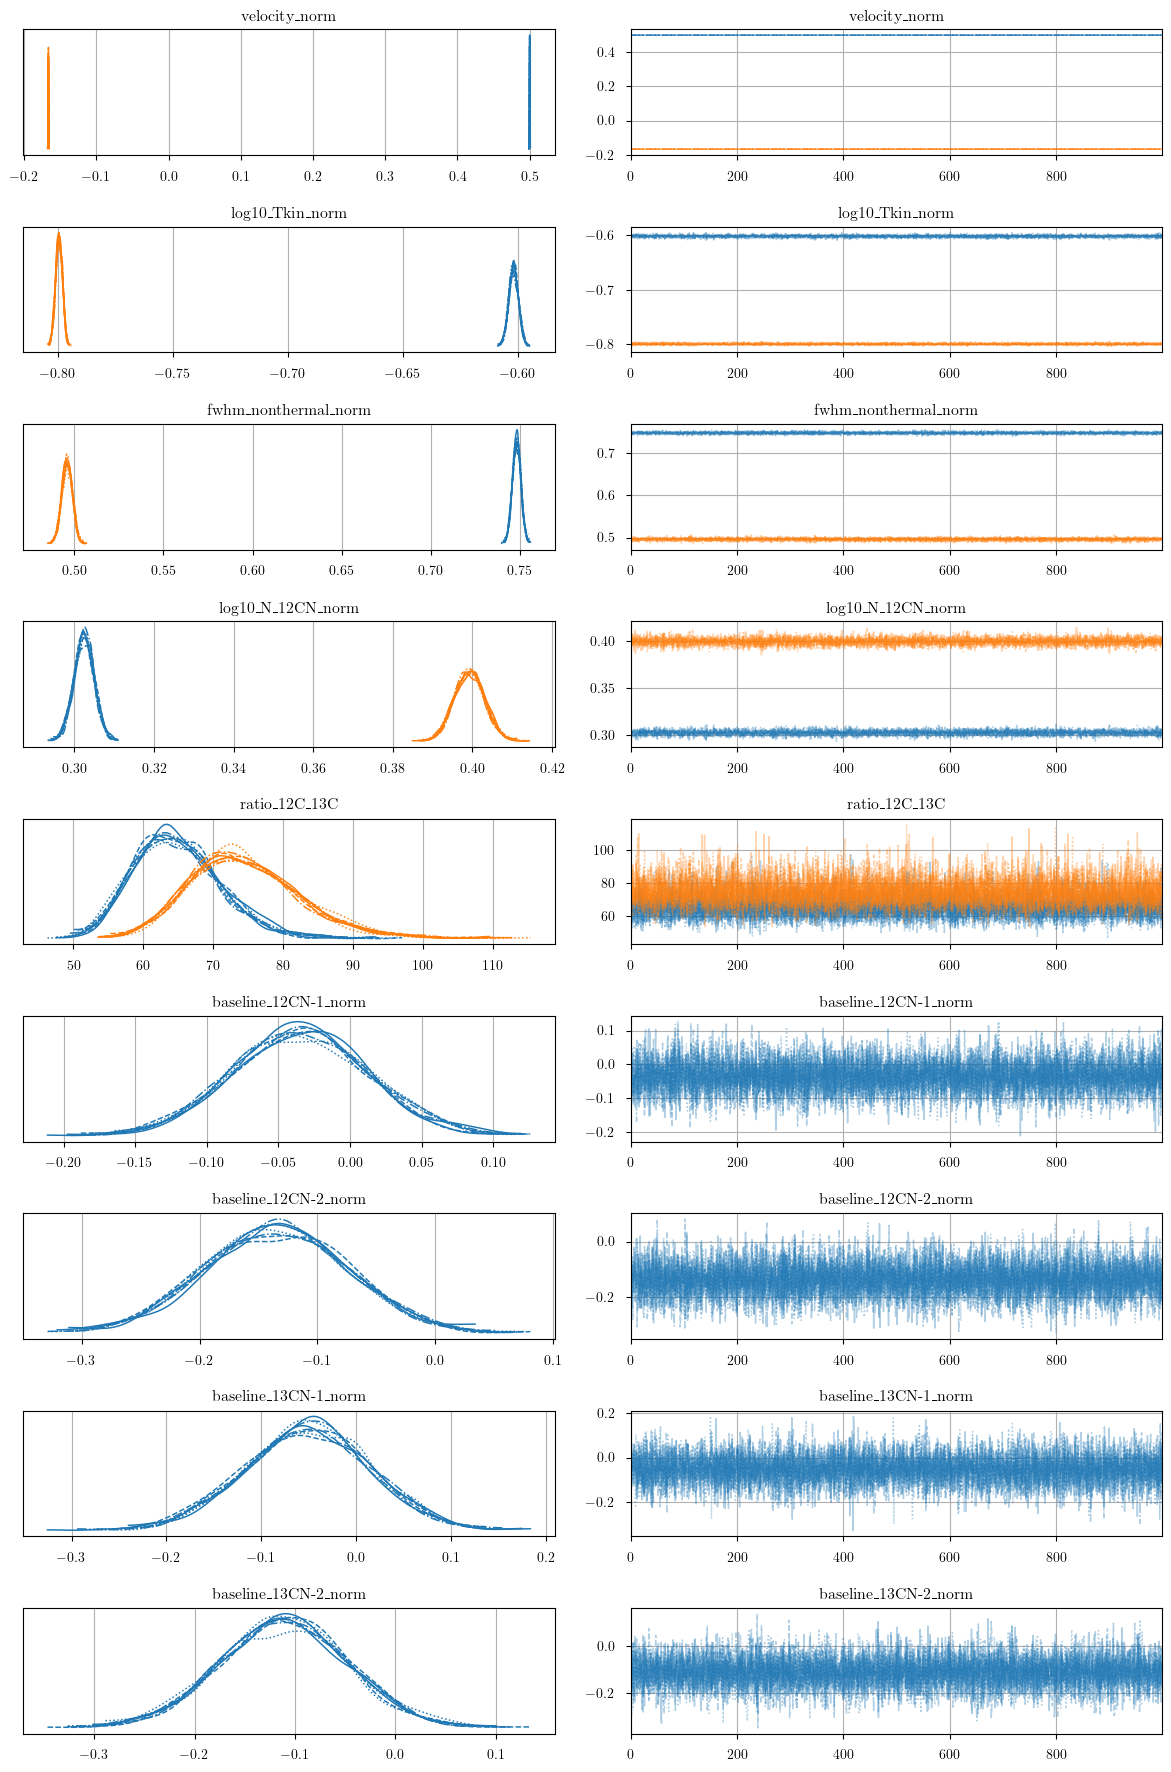

In [15]:
from bayes_spec.plots import plot_traces

axes = plot_traces(model.trace.solution_0, model.cloud_freeRVs + model.baseline_freeRVs + model.hyper_freeRVs)
fig = axes.ravel()[0].figure
fig.tight_layout()

We can inspect the posterior distribution pair plots. First, the normalized, free cloud parameters.

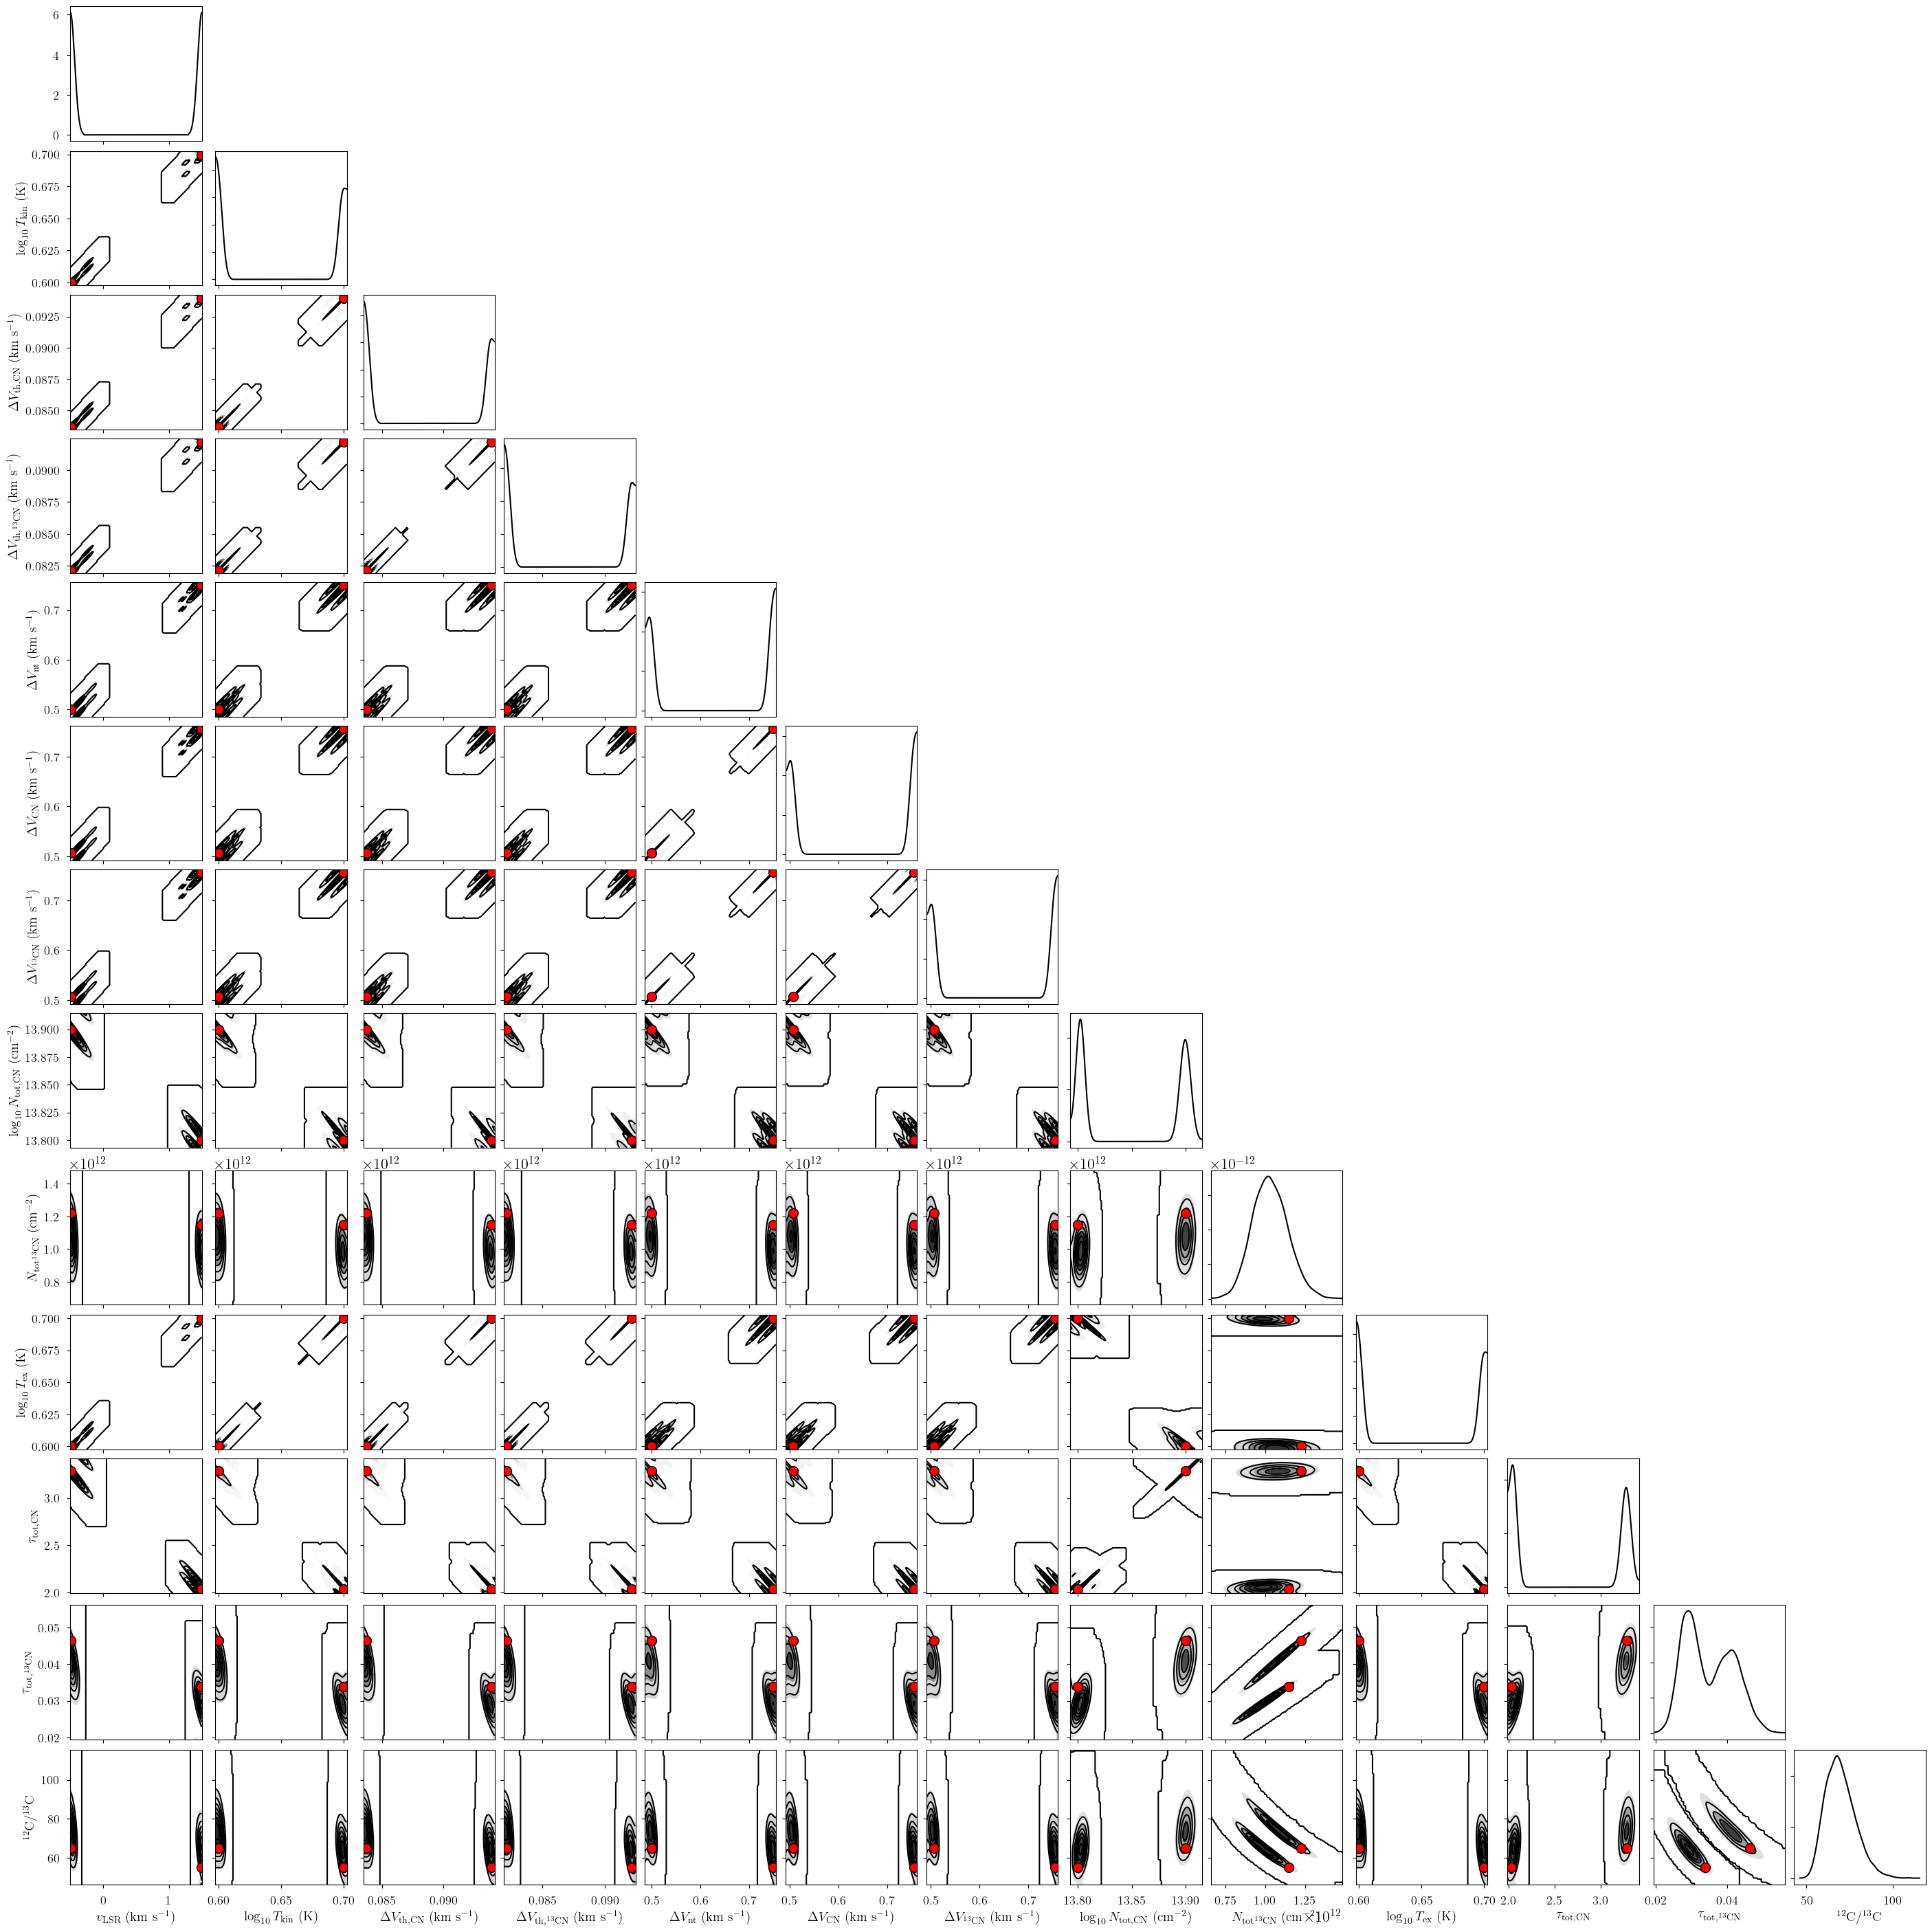

In [16]:
from bayes_spec.plots import plot_pair

var_names = [
    param for param in model.cloud_deterministics
    if not set(model.model.named_vars_to_dims[param]).intersection(set(
        ["transition_12CN", "state_12CN", "transition_13CN", "state_13CN"]
    ))
]
_ = plot_pair(
    model.trace.solution_0, # samples
    var_names + ["ratio_12C_13C"], # var_names to plot
    labeller=model.labeller, # label manager
    kind="kde", # plot type
    reference_values=sim_params, # truths
)

In [17]:
# identify simulation cloud corresponding to each posterior cloud
sim_cloud_map = {}
for i in range(n_clouds):
    posterior_velocity = model.trace.solution_0['velocity'].sel(cloud=i).data.mean()
    match = np.argmin(np.abs(sim_params["velocity"] - posterior_velocity))
    sim_cloud_map[i] = match
sim_cloud_map

{0: np.int64(1), 1: np.int64(0)}

['velocity', 'log10_Tkin', 'fwhm_thermal_12CN', 'fwhm_thermal_13CN', 'fwhm_nonthermal', 'fwhm_12CN', 'fwhm_13CN', 'log10_N_12CN', 'N_13CN', 'log10_Tex_ul', 'tau_total_12CN', 'tau_total_13CN']


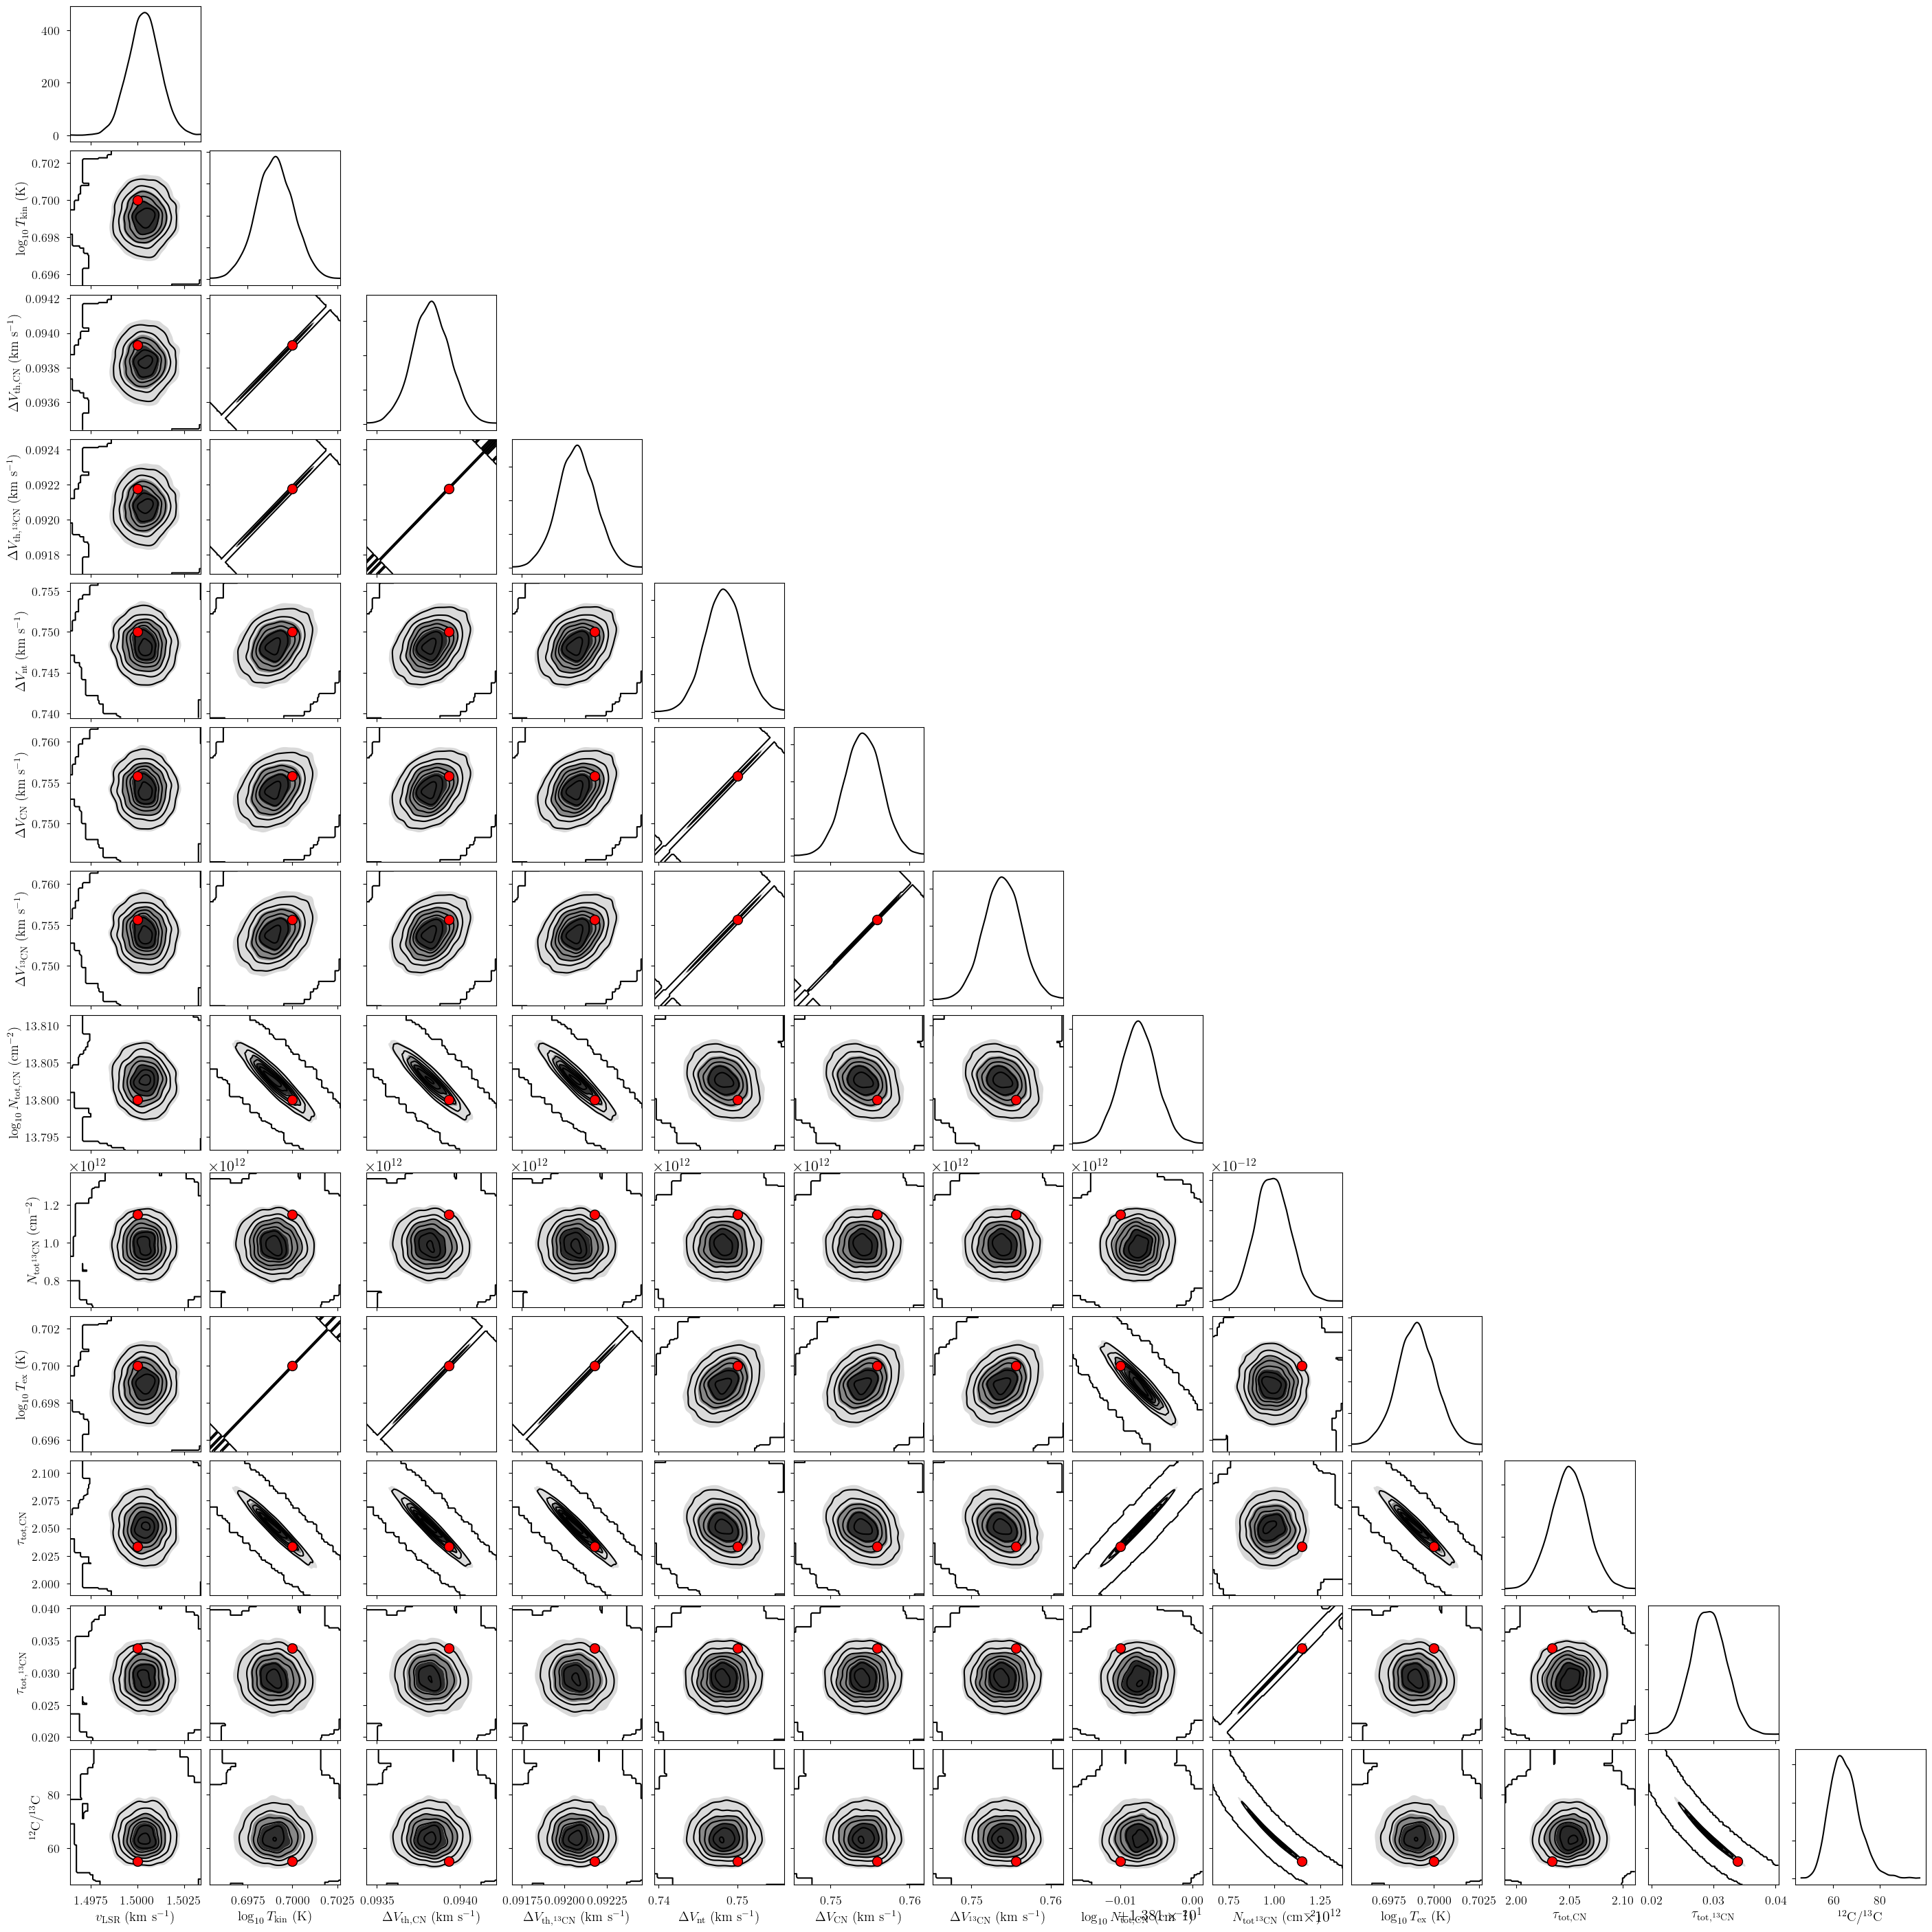

In [18]:
cloud = 0

# subset of sim_params
my_sim_params = {}
for var_name in model.cloud_deterministics + ["ratio_12C_13C"]:
    my_sim_params[var_name] = sim_params[var_name][sim_cloud_map[cloud]]
for var_name in model.hyper_deterministics:
    my_sim_params[var_name] = sim_params[var_name]

# ignore transition and state dependent parameters
var_names = [
    param for param in model.cloud_deterministics
    if not set(model.model.named_vars_to_dims[param]).intersection(set(
        ["transition_12CN", "state_12CN", "transition_13CN", "state_13CN"]
    ))
]
print(var_names)
_ = plot_pair(
    model.trace.solution_0.sel(cloud=cloud), # samples
    var_names + model.hyper_deterministics + ["ratio_12C_13C"], # var_names to plot
    labeller=model.labeller, # label manager
    kind="kde", # plot type
    reference_values=my_sim_params, # truths
)

['velocity', 'log10_Tkin', 'fwhm_thermal_12CN', 'fwhm_thermal_13CN', 'fwhm_nonthermal', 'fwhm_12CN', 'fwhm_13CN', 'log10_N_12CN', 'N_13CN', 'log10_Tex_ul', 'tau_total_12CN', 'tau_total_13CN']


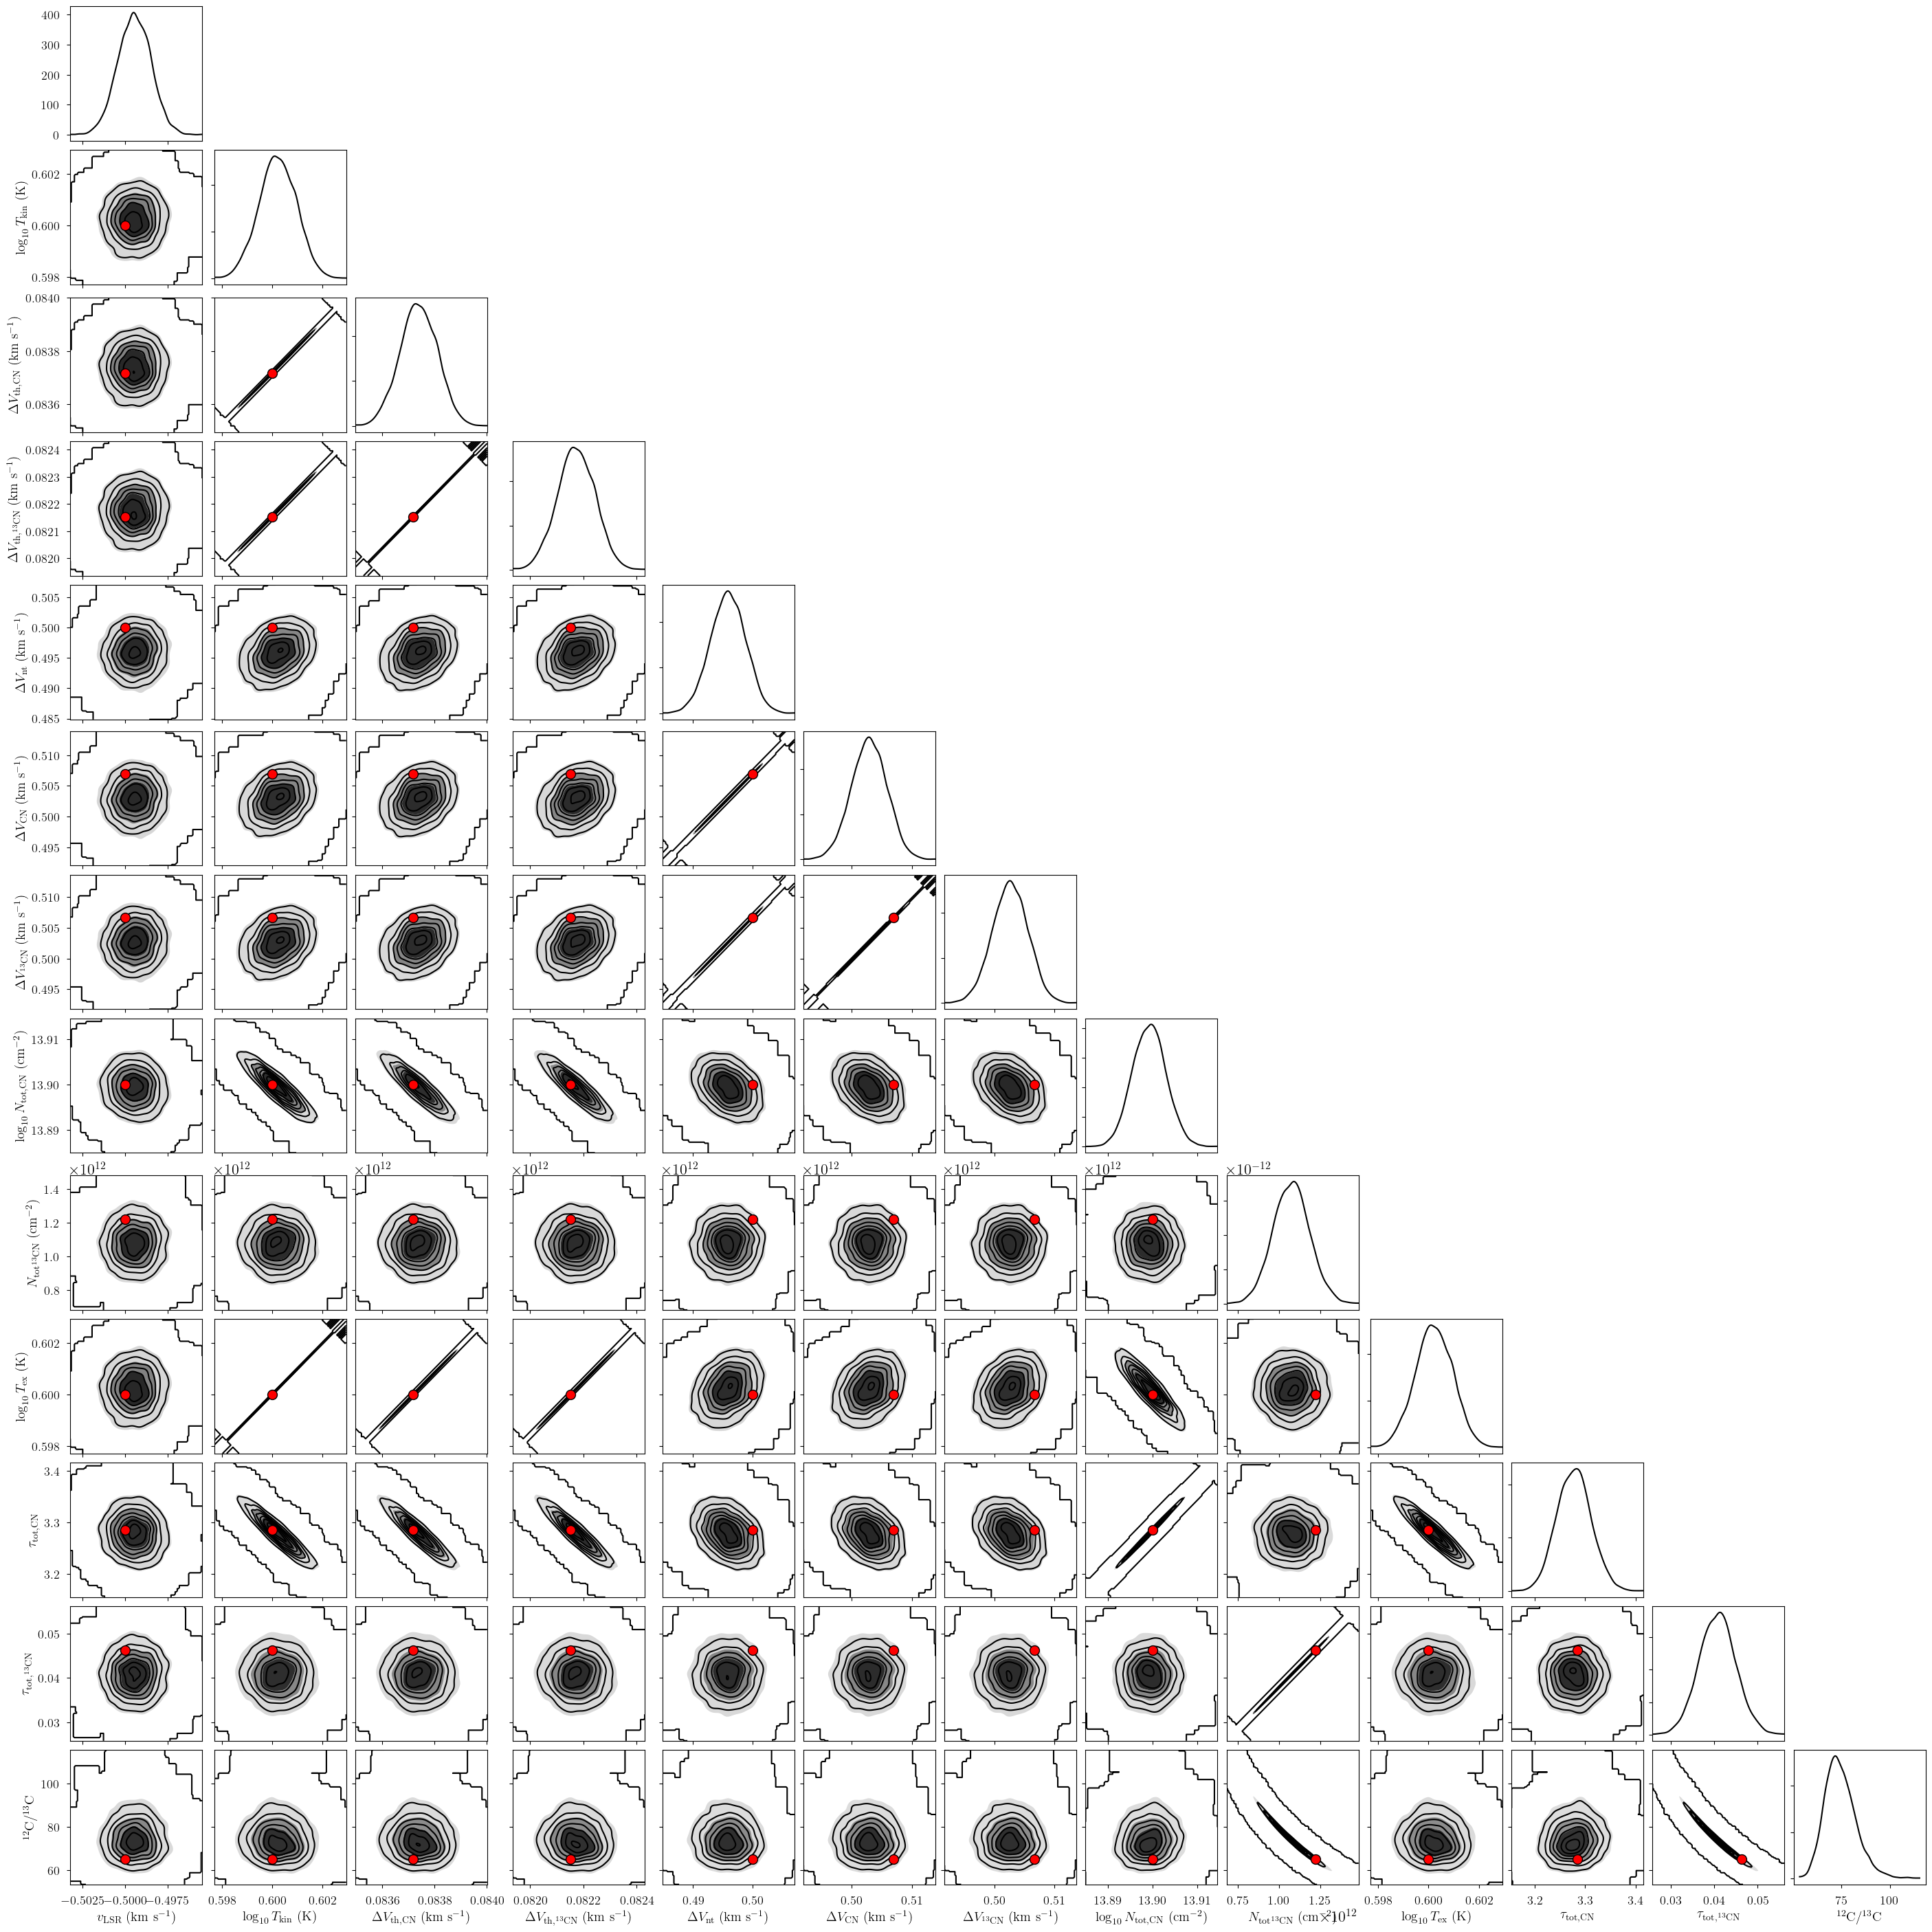

In [19]:
cloud = 1

# subset of sim_params
my_sim_params = {}
for var_name in model.cloud_deterministics + ["ratio_12C_13C"]:
    my_sim_params[var_name] = sim_params[var_name][sim_cloud_map[cloud]]
for var_name in model.hyper_deterministics:
    my_sim_params[var_name] = sim_params[var_name]

# ignore transition and state dependent parameters
var_names = [
    param for param in model.cloud_deterministics
    if not set(model.model.named_vars_to_dims[param]).intersection(set(
        ["transition_12CN", "state_12CN", "transition_13CN", "state_13CN"]
    ))
]
print(var_names)
_ = plot_pair(
    model.trace.solution_0.sel(cloud=cloud), # samples
    var_names + model.hyper_deterministics + ["ratio_12C_13C"], # var_names to plot
    labeller=model.labeller, # label manager
    kind="kde", # plot type
    reference_values=my_sim_params, # truths
)

In [20]:
var_names=model.cloud_deterministics + model.baseline_freeRVs + model.hyper_freeRVs + model.hyper_deterministics + ["ratio_12C_13C"]
point_stats = az.summary(model.trace.solution_0, var_names=var_names, kind='stats', hdi_prob=0.68)
print("BIC:", model.bic())
display(point_stats)

BIC: -9595.187251695064


mean            sd       hdi_16%  \
velocity[0]               1.500000e+00  1.000000e-03  1.500000e+00   
velocity[1]              -4.990000e-01  1.000000e-03 -5.000000e-01   
log10_Tkin[0]             6.990000e-01  1.000000e-03  6.980000e-01   
log10_Tkin[1]             6.000000e-01  1.000000e-03  6.000000e-01   
fwhm_thermal_12CN[0]      9.400000e-02  0.000000e+00  9.400000e-02   
fwhm_thermal_12CN[1]      8.400000e-02  0.000000e+00  8.400000e-02   
fwhm_thermal_13CN[0]      9.200000e-02  0.000000e+00  9.200000e-02   
fwhm_thermal_13CN[1]      8.200000e-02  0.000000e+00  8.200000e-02   
fwhm_nonthermal[0]        7.480000e-01  2.000000e-03  7.460000e-01   
fwhm_nonthermal[1]        4.960000e-01  3.000000e-03  4.930000e-01   
fwhm_12CN[0]              7.540000e-01  2.000000e-03  7.520000e-01   
fwhm_12CN[1]              5.030000e-01  3.000000e-03  5.000000e-01   
fwhm_13CN[0]              7.540000e-01  2.000000e-03  7.520000e-01   
fwhm_13CN[1]              5.030000e-01  3.000000e-03  5.000000e-01   
log10_N_12CN[0]           1.380200e+01  3.000000e-03  1.380000e+01   
log10_N_12CN[1]           1.389900e+01  4.000000e-03  1.389500e+01   
N_13CN[0]                 9.868061e+11  9.318424e+10  8.947238e+11   
N_13CN[1]                 1.074679e+12  1.113915e+11  9.672282e+11   
log10_Tex_ul[0]           6.990000e-01  1.000000e-03  6.980000e-01   
log10_Tex_ul[1]           6.000000e-01  1.000000e-03  6.000000e-01   
Tex_12CN[113123.3687, 0]  5.001000e+00  1.200000e-02  4.988000e+00   
Tex_12CN[113123.3687, 1]  3.983000e+00  7.000000e-03  3.976000e+00   
Tex_12CN[113144.19, 0]    5.001000e+00  1.200000e-02  4.988000e+00   
Tex_12CN[113144.19, 1]    3.983000e+00  7.000000e-03  3.976000e+00   
Tex_12CN[113170.535, 0]   5.001000e+00  1.200000e-02  4.988000e+00   
Tex_12CN[113170.535, 1]   3.983000e+00  7.000000e-03  3.976000e+00   
Tex_12CN[113191.325, 0]   5.001000e+00  1.200000e-02  4.988000e+00   
Tex_12CN[113191.325, 1]   3.983000e+00  7.000000e-03  3.976000e+00   
Tex_12CN[113488.142, 0]   5.001000e+00  1.200000e-02  4.988000e+00   
Tex_12CN[113488.142, 1]   3.983000e+00  7.000000e-03  3.976000e+00   
Tex_12CN[113490.985, 0]   5.001000e+00  1.200000e-02  4.988000e+00   
Tex_12CN[113490.985, 1]   3.983000e+00  7.000000e-03  3.976000e+00   
Tex_12CN[113499.643, 0]   5.001000e+00  1.200000e-02  4.988000e+00   
Tex_12CN[113499.643, 1]   3.983000e+00  7.000000e-03  3.976000e+00   
Tex_12CN[113508.934, 0]   5.001000e+00  1.200000e-02  4.988000e+00   
Tex_12CN[113508.934, 1]   3.983000e+00  7.000000e-03  3.976000e+00   
Tex_12CN[113520.4215, 0]  5.001000e+00  1.200000e-02  4.988000e+00   
Tex_12CN[113520.4215, 1]  3.983000e+00  7.000000e-03  3.976000e+00   
tau_12CN[113123.3687, 0]  2.500000e-02  0.000000e+00  2.500000e-02   
tau_12CN[113123.3687, 1]  4.000000e-02  0.000000e+00  3.900000e-02   
tau_12CN[113144.19, 0]    2.020000e-01  2.000000e-03  2.010000e-01   
tau_12CN[113144.19, 1]    3.240000e-01  3.000000e-03  3.200000e-01   
tau_12CN[113170.535, 0]   1.980000e-01  2.000000e-03  1.960000e-01   
tau_12CN[113170.535, 1]   3.160000e-01  3.000000e-03  3.130000e-01   
tau_12CN[113191.325, 0]   2.570000e-01  2.000000e-03  2.550000e-01   
tau_12CN[113191.325, 1]   4.100000e-01  4.000000e-03  4.060000e-01   
tau_12CN[113488.142, 0]   2.580000e-01  2.000000e-03  2.560000e-01   
tau_12CN[113488.142, 1]   4.120000e-01  4.000000e-03  4.070000e-01   
tau_12CN[113490.985, 0]   6.840000e-01  6.000000e-03  6.790000e-01   
tau_12CN[113490.985, 1]   1.094000e+00  1.100000e-02  1.082000e+00   
tau_12CN[113499.643, 0]   2.030000e-01  2.000000e-03  2.020000e-01   
tau_12CN[113499.643, 1]   3.250000e-01  3.000000e-03  3.210000e-01   
tau_12CN[113508.934, 0]   1.990000e-01  2.000000e-03  1.970000e-01   
tau_12CN[113508.934, 1]   3.180000e-01  3.000000e-03  3.140000e-01   
tau_12CN[113520.4215, 0]  2.500000e-02  0.000000e+00  2.500000e-02   
tau_12CN[113520.4215, 1]  4.000000e-02  0.000000e+00  3.900000e-02   
tau_total_12CN[0]         2.050000e+00  1.70